# Курсовая работа 
Выполнила: Иваницкая Алиса 
M8O-114СВ-24

Описание датасета Dota 2 Matches

Датасет содержит информацию о матчах в игре Dota 2. Каждый матч представлен рядом характеристик, которые могут быть использованы для анализа и предсказания результатов матчей. Данные состоят из нескольких столбцов, каждый из которых описывает определенный аспект матча:

1. Match ID: Уникальный идентификатор матча.
2. Start Time: Время начала матча в формате Unix timestamp.
3. Duration: Продолжительность матча в секундах.
4. Tower Status Radiant: Статус башен команды Radiant (значение указывает на количество оставшихся башен).
5. Tower Status Dire: Статус башен команды Dire.
6. Barracks Status Radiant: Статус казарм команды Radiant.
7. Barracks Status Dire: Статус казарм команды Dire.
8. Cluster: Идентификатор кластера, в котором был сыгран матч (может указывать на географическое расположение серверов).
9. First Blood Time: Время, когда произошло первое убийство в матче.
10. Lobby Type: Тип лобби, в котором был сыгран матч (например, публичное или приватное).
11. Game Mode: Режим игры, в котором был сыгран матч (например, All Pick, Captains Mode).
12. Radiant Win: Булевый индикатор, указывающий, выиграла ли команда Radiant (True, если выиграла, иначе False).


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from torch.utils.data import Dataset, DataLoader
import torch
from pprint import pprint
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_absolute_error
import numpy as np

In [2]:
df = pd.read_csv('match.csv')
df

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,1447829192,3025,1824,0,0,63,117,22,True,0,0,111
49996,49996,1447829181,1451,1982,384,48,63,147,22,True,0,0,204
49997,49997,1447829197,2672,1830,0,0,63,130,22,True,0,0,111
49998,49998,1447829189,2211,1982,4,3,63,645,22,True,0,0,151


In [3]:
df.describe()

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,negative_votes,positive_votes,cluster
count,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,1.447573e+09,2476.453500,1000.016440,935.250060,34.529460,34.77526,93.825520,21.468000,0.015480,0.036820,142.304720
std,14433.901067,1.485270e+05,634.631261,948.211846,937.974714,29.209672,29.73214,92.648332,3.218258,0.364696,0.871068,25.156608
min,0.000000,1.446750e+09,59.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000,0.000000,0.000000,111.000000
25%,12499.750000,1.447456e+09,2029.000000,0.000000,0.000000,0.000000,0.00000,9.000000,22.000000,0.000000,0.000000,123.000000
50%,24999.500000,1.447577e+09,2415.000000,1536.000000,384.000000,51.000000,51.00000,77.000000,22.000000,0.000000,0.000000,133.000000
75%,37499.250000,1.447700e+09,2872.000000,1974.000000,1972.000000,63.000000,63.00000,144.000000,22.000000,0.000000,0.000000,154.000000
max,49999.000000,1.447829e+09,16037.000000,2047.000000,2047.000000,63.000000,63.00000,831.000000,22.000000,47.000000,80.000000,242.000000


### Dataloader

In [4]:
# Преобразовать начальное время UNIX в текущее время
df['start_time'] = pd.to_datetime(df['start_time'], unit='s')

In [5]:
class Dota2Dataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.df.iloc[idx]
        # Преобразуем pandas.Series в словарь
        sample_dict = sample.to_dict()
        return sample_dict

# Пример использования
dota2_dataset = Dota2Dataset(csv_file='match.csv')
dataloader = DataLoader(dota2_dataset, batch_size=4, shuffle=True)

# Пример итерации по данным
for i, df in enumerate(dataloader):
    print(df)
    print('\n')
    if i == 1:  
        break

{'match_id': tensor([30173, 38676,  4975,  9564]), 'start_time': tensor([1447617575, 1447709931, 1447364222, 1447427127]), 'duration': tensor([1991, 2262, 3728, 2843]), 'tower_status_radiant': tensor([   4, 1974,  260, 1584]), 'tower_status_dire': tensor([1828,    0,    0,  256]), 'barracks_status_dire': tensor([63,  0,  0, 48]), 'barracks_status_radiant': tensor([ 3, 63, 51, 14]), 'first_blood_time': tensor([  0, 106,  16, 140]), 'game_mode': tensor([22, 22, 22, 22]), 'radiant_win': tensor([False,  True,  True,  True]), 'negative_votes': tensor([0, 0, 0, 0]), 'positive_votes': tensor([0, 0, 0, 0]), 'cluster': tensor([187, 121, 181, 156])}


{'match_id': tensor([16667, 38431, 10642,  1124]), 'start_time': tensor([1447503364, 1447708222, 1447440128, 1447325413]), 'duration': tensor([2653, 3620, 2263, 2639]), 'tower_status_radiant': tensor([   0,    0, 1974, 1844]), 'tower_status_dire': tensor([1844, 1796,  384,    4]), 'barracks_status_dire': tensor([63, 51, 48,  3]), 'barracks_status_r

In [6]:
df = pd.read_csv('match.csv')
df

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,1447829192,3025,1824,0,0,63,117,22,True,0,0,111
49996,49996,1447829181,1451,1982,384,48,63,147,22,True,0,0,204
49997,49997,1447829197,2672,1830,0,0,63,130,22,True,0,0,111
49998,49998,1447829189,2211,1982,4,3,63,645,22,True,0,0,151


### Статистика: 
* Количество записей и полей

In [7]:
num_records = len(df)
num_fields = df.shape[1]

print(f"Количество записей: {num_records}")
print(f"Количество полей: {num_fields}")

Количество записей: 50000
Количество полей: 13


* Объём одной записи в битах

In [8]:
memory_usage_bytes = df.memory_usage(deep=True).sum()
record_size_bytes = memory_usage_bytes / len(df)
record_size_bits = record_size_bytes * 8 
print(f"Объём одной записи в битах: {record_size_bits:.2f} бит")

Объём одной записи в битах: 776.02 бит


* Количество признаков

In [9]:
num_features = num_fields
print(f"Количество признаков: {num_features}")

Количество признаков: 13


* Процент выигранных матчей

In [10]:
if 'radiant_win' in df.columns:
    # Количество выигранных матчей
    num_wins = df['radiant_win'].sum()
    # Общее количество матчей
    total_matches = len(df)
    # Процент выигранных матчей
    win_percentage = (num_wins / total_matches) * 100
    # Вывод результата
    print(f"Процент выигранных матчей: {win_percentage:.2f}%")
else:
    print("Столбец 'radiant_win' не найден в данных.")

Процент выигранных матчей: 51.89%


* Количество пропусков

In [11]:
missing_values = df.isnull().sum()
print("Количество пропусков:", missing_values)

Количество пропусков: match_id                   0
start_time                 0
duration                   0
tower_status_radiant       0
tower_status_dire          0
barracks_status_dire       0
barracks_status_radiant    0
first_blood_time           0
game_mode                  0
radiant_win                0
negative_votes             0
positive_votes             0
cluster                    0
dtype: int64


* Типы данных

In [12]:
data_types = df.dtypes
print("Типы данных:", data_types)

Типы данных: match_id                   int64
start_time                 int64
duration                   int64
tower_status_radiant       int64
tower_status_dire          int64
barracks_status_dire       int64
barracks_status_radiant    int64
first_blood_time           int64
game_mode                  int64
radiant_win                 bool
negative_votes             int64
positive_votes             int64
cluster                    int64
dtype: object


* Гистограмма для определения продолжительности матча

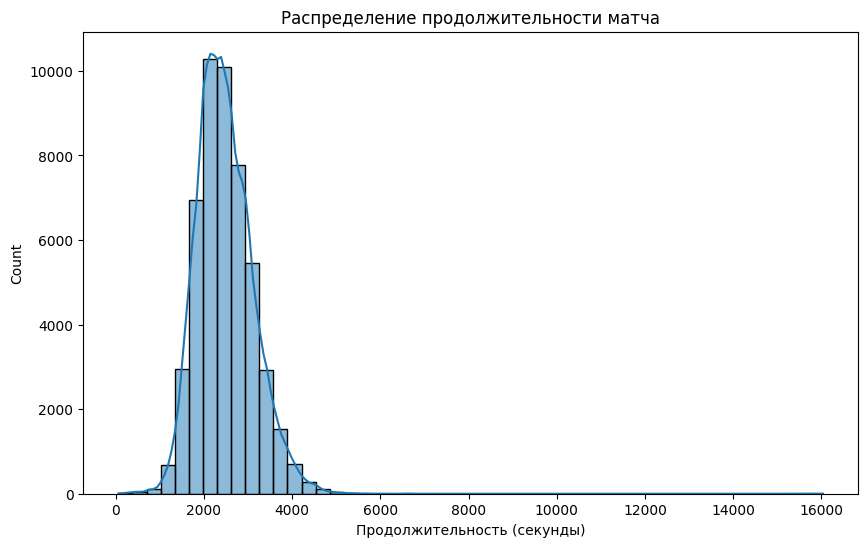

In [13]:
plt.figure(figsize=(10,6))
sns.histplot(df['duration'], bins=50, kde=True)
plt.title('Распределение продолжительности матча')
plt.xlabel('Продолжительность (секунды)')
plt.show()

* Корреляционная матрица

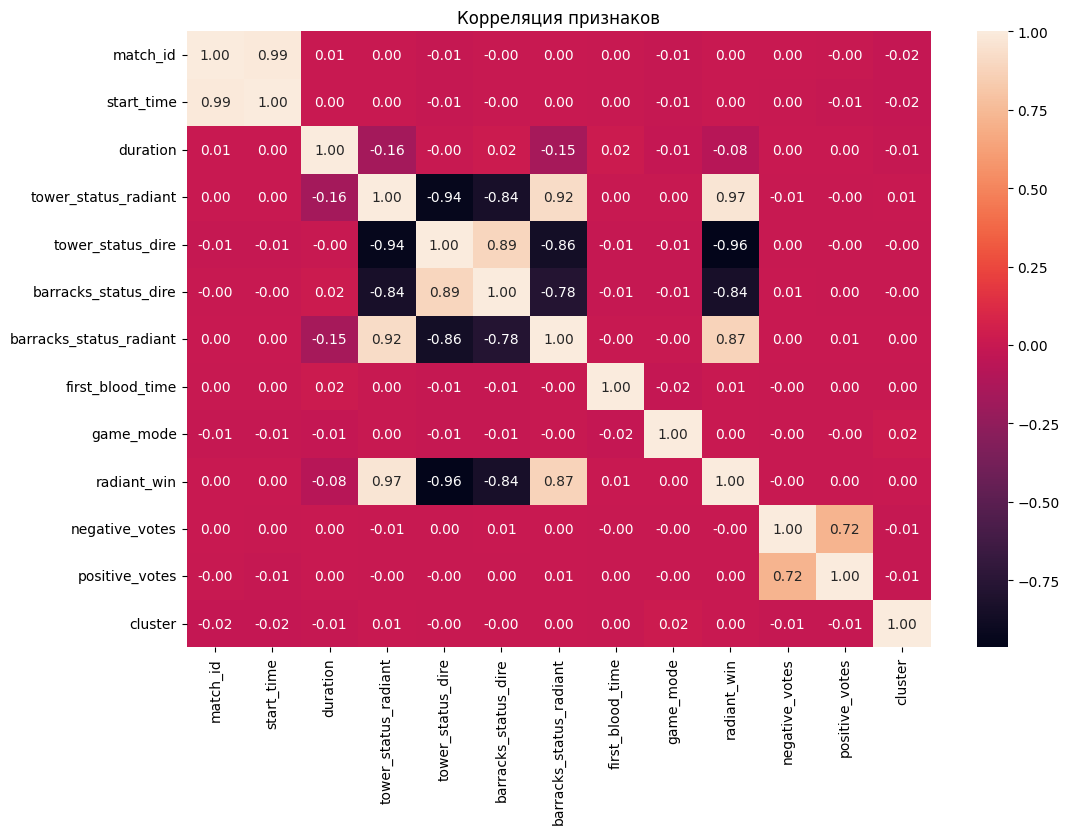

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title('Корреляция признаков')
plt.show()

### Кластеризация

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


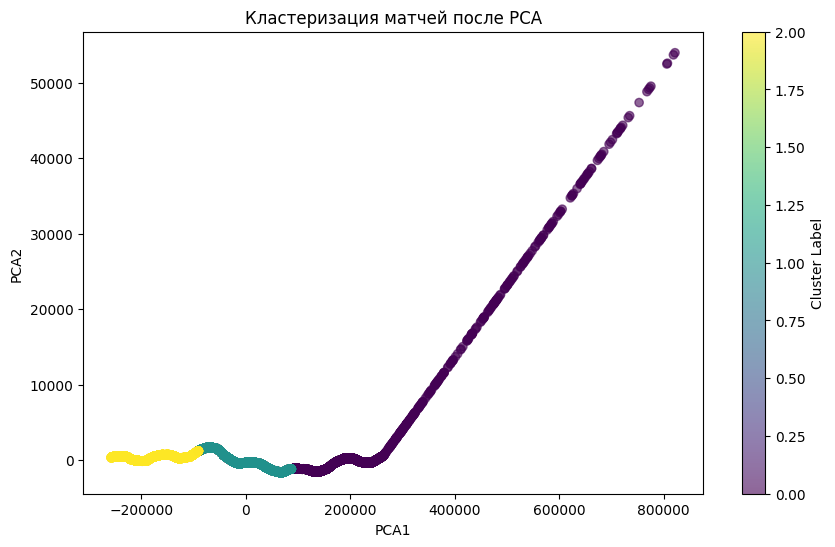

In [15]:
# Извлечение признаков
features = df.iloc[:, :-1].values

# Понижение размерности для визуализации
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

# Визуализация кластеризации с использованием PCA
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("Кластеризация матчей после PCA")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster Label')
plt.show()

### Outliers (выбросы)

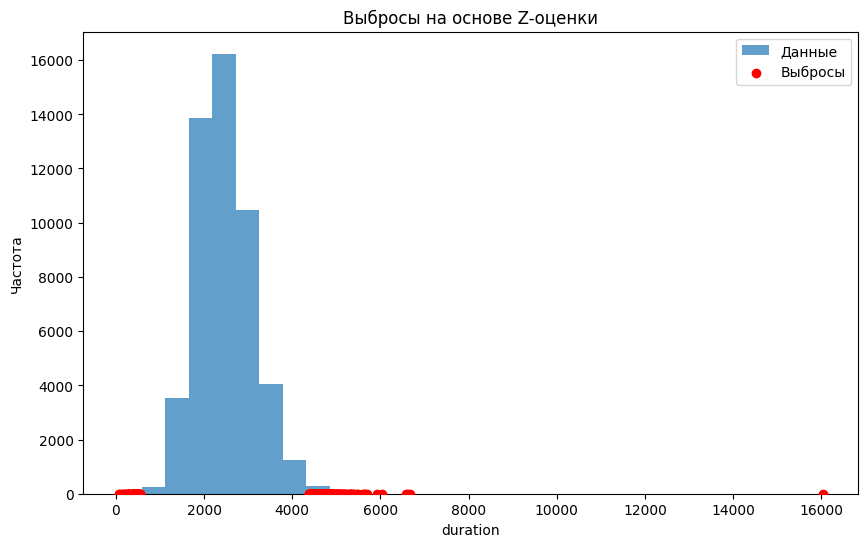

In [16]:
# Выбор столбца для анализа
column = 'duration'

# Вычисление Z-оценок
z_scores = stats.zscore(df[column])

# Определение выбросов (по модулю Z-оценка > 3 считается выбросом)
threshold = 3
outliers = df[abs(z_scores) > threshold]

# Построение графика
plt.figure(figsize=(10, 6))
plt.hist(df[column], bins=30, alpha=0.7, label='Данные')
plt.scatter(outliers[column], [0] * len(outliers), color='red', label='Выбросы', zorder=5)
plt.title('Выбросы на основе Z-оценки')
plt.xlabel(column)
plt.ylabel('Частота')
plt.legend()
plt.show()

### Метод опорных векторов (SVM)
это мощный алгоритм машинного обучения, который используется для классификации и регрессии. В своей основе SVM находит гиперплоскость, которая наилучшим образом разделяет данные на разные классы.

Процесс работы метода SVM включает несколько ключевых шагов и понятий:
* Гиперплоскость: Гиперплоскость - это обобщение понятия линии в пространстве, которое разделяет данные на классы. В двумерном пространстве это прямая, а в трехмерном - плоскость.
* Опорные векторы: Опорные векторы - это данные, которые лежат ближе всего к гиперплоскости. Они являются критически важными для определения позиции гиперплоскости, поскольку именно они воздействуют на ее наклон и положение.
* Максимизация зазора: Принцип работы SVM заключается в том, чтобы максимально увеличить расстояние (зазор) между опорными векторами разных классов и гиперплоскостью. Это необходимо для достижения максимальной обобщающей способности модели.
* Ядровые функции: Поскольку данные могут быть не линейно разделимы, SVM использует ядровые функции. Ядерные функции позволяют преобразовать исходные данные в пространство более высокого порядка, где данные могут стать линейно разделимыми. Это делает SVM очень гибким и мощным инструментом для работы с различными типами данных.
* Регуляризация: В SVM также есть параметр регуляризации, который контролирует компромисс между максимизацией зазора и минимизацией ошибки классификации. Это позволяет SVM подходить к данным, не переобучаясь.

[[4758   57]
 [  34 5151]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4815
           1       0.99      0.99      0.99      5185

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

MAE: 0.0091


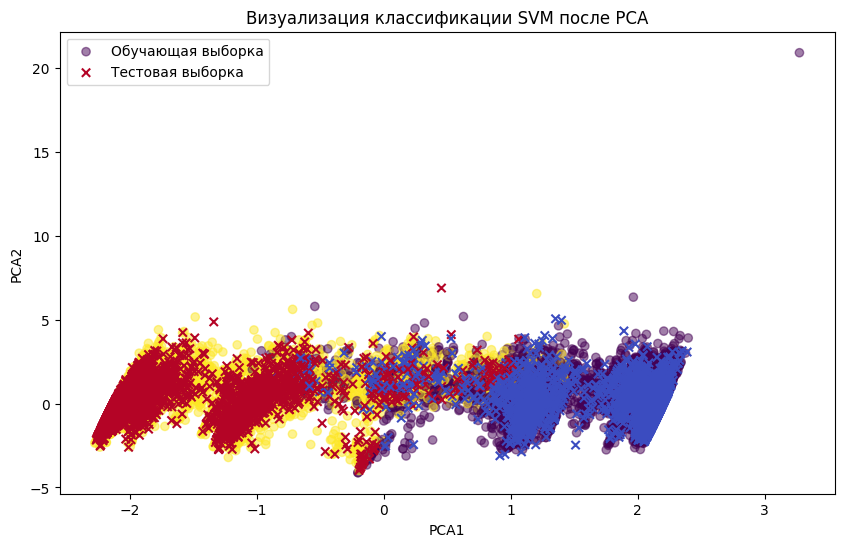

In [22]:
X = df[['duration', 'tower_status_radiant', 'tower_status_dire',
        'barracks_status_radiant', 'barracks_status_dire']]
y = df['radiant_win'].astype(int)  # Преобразуем логические значения в int

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SVC(kernel='linear')  
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Оценка производительности модели
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Визуализация данных
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5, label='Обучающая выборка')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='coolwarm', marker='x', label='Тестовая выборка')

plt.title('Визуализация классификации SVM после PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

### ML Systems Design для предсказания исхода матчей Dota 2 с применением SVM

Цель: Разработка модели, способной предсказывать результаты матчей в игре Dota 2, путем анализа прошлых событий. Доступная информация охватывает изначальное время игры, длительность, состояние башен и казарм, время первого убийства, фомат лобби и тип игры.

Почему SVM выбран в данном контексте:
* Высокая эффективность: SVM демонстрирует превосходные результаты в задачах классификации, например, в определении успеха команды Radiant, благодаря своему умению раскрывать сложные связи между различными характеристиками.
* Стабильность против переобучения: включенный процесс регуляризации гарантирует предотвращение переобучения, что имеет первостепенное значение при обработке игровых данных, содержащих много шума.

Однако данная модель имеет и свои недостатки:
* Настройка гиперпараметров: Для достижения максимально эффективных результатов, потребуется значительное время на настройку гиперпараметров. В нашем случае было проведено около 50 попыток для обнаружения оптимальных значений.
* Чувствительность к выбросам: Несмотря на то, что SVM менее чувствителен к выбросам, по сравнению с некоторыми другими алгоритмами, он все равно может быть на них реактивен. Для решения этой проблемы были использованы методики обработки выбросов и балансировки классов.

Применение данный модели в рабочих системах:
* Анализ и предсказание результатов матчей: Модель может быть использована для прогнозирования результатов игры в режиме реального времени, что может быть полезно аналитикам и комментаторам.
* Оптимизация стратегии игры: Базируясь на прогнозах, можно разрабатывать стратегии для повышения вероятности победы, анализируя ключевые факторы, которые влияют на результат матча.
* Помощь киберспортсменам: Киберспортивные команды могут использовать данный метод для анализа своих игр и игр противников, чтобы определить свои сильные и слабые стороны.
* Разработка обучающих программ: Модель может быть весьма полезной при создании обучающих программ для новых игроков, показывая какие моменты игры наиболее критичны для победы.
